In [15]:
import re
from pathlib import Path
from pprint import pp

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from P03_run_diff_sigma.T00_lib.classes_ml import MyUtil
from P03_run_diff_sigma.T00_lib.utils import check_jupyter

In [16]:
SAVE_DATA = False
MAKE_ONE_HOT = True

In [17]:
if check_jupyter():
    BASE_DIR = Path.cwd()  # Current directory of the running file
    DATA_DIR = BASE_DIR.parent / "T02_combine_features"
    CURRENT_DIR = BASE_DIR
else:
    BASE_DIR = Path.cwd()  # Base directory of the project
    DATA_DIR = BASE_DIR / "src/P3_run_diff_sigma/T02_combine_features"
    CURRENT_DIR = Path(__file__).resolve().parent

dt = MyUtil.get_dt()
print(f"Current Directory: {CURRENT_DIR}")
print(f"Current Date and Time: {dt}")

# Load data
df = pd.read_excel(DATA_DIR / "S02_data_combined_loc.xlsx")
print(df.shape)
df

Code is running in a Jupyter environment.
Current Directory: c:\Users\admin\Coding\research\weld-ml\src\P03_run_diff_sigma\T31_tabpfn
Current Date and Time: 2026-01-23_13-44
(378, 180)


,sample_no,R,W,D,position,location,fz_location,"dwell_Fz__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""",dwell_Fz__mean_change,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","dwell_Fz__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0",dwell_Fz__partial_autocorrelation__lag_3,dwell_Fz__approximate_entropy__m_2__r_0.9,"dwell_Fz__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","dwell_Fz__fft_coefficient__attr_""real""__coeff_4",dwell_Fz__partial_autocorrelation__lag_7,dwell_Fz__symmetry_looking__r_0.05,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.8","dwell_Fz__fft_coefficient__attr_""angle""__coeff_88","dwell_Fz__fft_coefficient__attr_""angle""__coeff_4",dwell_Fz__binned_entropy__max_bins_10,"dwell_Fz__fft_coefficient__attr_""angle""__coeff_32","dwell_Fz__fft_coefficient__attr_""angle""__coeff_6","dwell_Fz__fft_coefficient__attr_""angle""__coeff_10","dwell_Fz__fft_coefficient__attr_""angle""__coeff_18","dwell_Fz__fft_coefficient__attr_""angle""__coeff_19","dwell_Fz__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","dwell_Fz__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""",dwell_Fz__ar_coefficient__coeff_6__k_10,"dwell_Fz__fft_coefficient__attr_""angle""__coeff_44","dwell_Fz__fft_coefficient__attr_""angle""__coeff_64","dwell_Fz__fft_coefficient__attr_""real""__coeff_90",dwell_Fz__autocorrelation__lag_0,"dwell_Fz__fft_coefficient__attr_""angle""__coeff_90","dwell_Fz__fft_coefficient__attr_""angle""__coeff_61","dwell_Fz__fft_coefficient__attr_""angle""__coeff_35",dwell_Fz__ratio_beyond_r_sigma__r_0.5,"dwell_Fz__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2",...,weld_Fz__absolute_sum_of_changes,"weld_Fz__fft_coefficient__attr_""abs""__coeff_3","weld_Fz__cwt_coefficients__coeff_10__w_2__widths_(2, 5, 10, 20)",weld_Fz__number_peaks__n_10,"weld_Fz__fft_coefficient__attr_""abs""__coeff_4","weld_Fz__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""min""",weld_Fz__ratio_beyond_r_sigma__r_1,"weld_Fz__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","weld_Fz__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""max""","weld_Fz__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","weld_Fz__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","weld_Fz__fft_coefficient__attr_""imag""__coeff_75","weld_Fz__fft_coefficient__attr_""imag""__coeff_98","weld_Fz__fft_coefficient__attr_""imag""__coeff_67","weld_Fz__fft_coefficient__attr_""imag""__coeff_91","weld_Fz__fft_coefficient__attr_""imag""__coeff_65","weld_Fz__fft_coefficient__attr_""imag""__coeff_59","weld_Fz__fft_coefficient__attr_""imag""__coeff_62","weld_Fz__fft_coefficient__attr_""imag""__coeff_61","weld_Fz__fft_coefficient__attr_""imag""__coeff_11",weld_Fz__skewness,weld_Fz__permutation_entropy__dimension_7__tau_1,weld_Fz__last_location_of_minimum,"weld_Fz__fft_coefficient__attr_""angle""__coeff_56",weld_Fz__permutation_entropy__dimension_6__tau_1,"weld_Fz__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)",weld_Fz__ar_coefficient__coeff_5__k_10,"weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","weld_Fz__fft_coefficient__attr_""real""__coeff_9","weld_Fz__fft_coefficient__attr_""real""__coeff_6","weld_Fz__fft_coefficient__attr_""angle""__coeff_26","weld_Fz__fft_coefficient__attr_""angle""__coeff_86","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",weld_Fz__ratio_beyond_r_sigma__r_2.5,weld_Fz__binned_entropy__max_bins_10,weld_Fz__kurtosis,stress_value_5052,stress_value_6061,stress_value_center
0,1,1400,60,10,0.153846,1,1.244326,-0.015598,-0.000466,-0.000466,0.054540,0.003409,0.001578,0.764136,0.328793,0.003156,10.030128,0.150247,

In [18]:
colsY = [c for c in df.columns if re.search(r"stress_value", c)]
print(colsY)
colsX = [c for c in df.columns if c not in colsY]
print(colsX)

['stress_value_5052', 'stress_value_6061', 'stress_value_center']
['sample_no', 'R', 'W', 'D', 'position', 'location', 'fz_location', 'dwell_Fz__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'dwell_Fz__mean_change', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'dwell_Fz__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'dwell_Fz__partial_autocorrelation__lag_3', 'dwell_Fz__approximate_entropy__m_2__r_0.9', 'dwell_Fz__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'dwell_Fz__fft_coefficient__attr_"real"__coeff_4', 'dwell_Fz__partial_autocorrelation__lag_7', 'dwell_Fz__symmetry_looking__r_0.05', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_88', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_4', 'dw

In [19]:
dfY = df[colsY]
dfX_all = df[colsX]

In [20]:
if MAKE_ONE_HOT:
    dft1 = pd.get_dummies(
        dfX_all, columns=["location", "R", "W", "D"], drop_first=False, dtype=int
    )
    dfX = dft1.drop(columns=["sample_no"])
else:
    dfX = dfX_all.drop(columns=["sample_no", "location"])
dfX

,position,fz_location,"dwell_Fz__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""",dwell_Fz__mean_change,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","dwell_Fz__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.0",dwell_Fz__partial_autocorrelation__lag_3,dwell_Fz__approximate_entropy__m_2__r_0.9,"dwell_Fz__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","dwell_Fz__fft_coefficient__attr_""real""__coeff_4",dwell_Fz__partial_autocorrelation__lag_7,dwell_Fz__symmetry_looking__r_0.05,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.8","dwell_Fz__fft_coefficient__attr_""angle""__coeff_88","dwell_Fz__fft_coefficient__attr_""angle""__coeff_4",dwell_Fz__binned_entropy__max_bins_10,"dwell_Fz__fft_coefficient__attr_""angle""__coeff_32","dwell_Fz__fft_coefficient__attr_""angle""__coeff_6","dwell_Fz__fft_coefficient__attr_""angle""__coeff_10","dwell_Fz__fft_coefficient__attr_""angle""__coeff_18","dwell_Fz__fft_coefficient__attr_""angle""__coeff_19","dwell_Fz__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","dwell_Fz__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""",dwell_Fz__ar_coefficient__coeff_6__k_10,"dwell_Fz__fft_coefficient__attr_""angle""__coeff_44","dwell_Fz__fft_coefficient__attr_""angle""__coeff_64","dwell_Fz__fft_coefficient__attr_""real""__coeff_90",dwell_Fz__autocorrelation__lag_0,"dwell_Fz__fft_coefficient__attr_""angle""__coeff_90","dwell_Fz__fft_coefficient__attr_""angle""__coeff_61","dwell_Fz__fft_coefficient__attr_""angle""__coeff_35",dwell_Fz__ratio_beyond_r_sigma__r_0.5,"dwell_Fz__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",dwell_Fz__lempel_ziv_complexity__bins_2,"dwell_Fz__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","dwell_Fz__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.2",...,"weld_Fz__fft_coefficient__attr_""imag""__coeff_67","weld_Fz__fft_coefficient__attr_""imag""__coeff_91","weld_Fz__fft_coefficient__attr_""imag""__coeff_65","weld_Fz__fft_coefficient__attr_""imag""__coeff_59","weld_Fz__fft_coefficient__attr_""imag""__coeff_62","weld_Fz__fft_coefficient__attr_""imag""__coeff_61","weld_Fz__fft_coefficient__attr_""imag""__coeff_11",weld_Fz__skewness,weld_Fz__permutation_entropy__dimension_7__tau_1,weld_Fz__last_location_of_minimum,"weld_Fz__fft_coefficient__attr_""angle""__coeff_56",weld_Fz__permutation_entropy__dimension_6__tau_1,"weld_Fz__cwt_coefficients__coeff_14__w_2__widths_(2, 5, 10, 20)",weld_Fz__ar_coefficient__coeff_5__k_10,"weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","weld_Fz__fft_coefficient__attr_""real""__coeff_9","weld_Fz__fft_coefficient__attr_""real""__coeff_6","weld_Fz__fft_coefficient__attr_""angle""__coeff_26","weld_Fz__fft_coefficient__attr_""angle""__coeff_86","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",weld_Fz__ratio_beyond_r_sigma__r_2.5,weld_Fz__binned_entropy__max_bins_10,weld_Fz__kurtosis,location_1,location_2,location_3,location_4,location_5,location_6,location_7,R_1400,R_1500,R_1600,W_60,W_70,W_80,D_10,D_15,D_20
0,0.153846,1.244326,-0.015598,-0.000466,-0.000466,0.054540,0.003409,0.001578,0.764136,0.328793,0.003156,10.030128,0.150247,1,-0.002716,-23.325537,-57.807789,1.599008,-79.640009,-63.634896,-74.374240,-71.473222,-72.412071,0.000273,0.005102,0.052888,-73.060211,-82.070137,0.261180,1.0,-75.770418,-65.405284,-81.793207,0.520480,0.003999,0.066223,0.054870,0.057942,-0.014223,0.000260,...,-3.871612,-1.086121,-2.244795,-3.902042,-3.451648,-7.513762,-60.958621,-1.000636,6.842932,1.000000,-77.326889,5.627806

In [21]:
# Extract features and targets
_X = dfX.values
_Y = dfY.values

print(_X.shape)
print(_Y.shape)

(378, 188)
(378, 3)


In [22]:
_X_train, _X_test, _Y_train, _Y_test = train_test_split(
    _X, _Y, test_size=0.3, random_state=0
)
print(_X_train.shape)
print(_X_test.shape)
print(_Y_train.shape)
print(_Y_test.shape)

(264, 188)
(114, 188)
(264, 3)
(114, 3)


In [23]:
scX = StandardScaler()
X_train = scX.fit_transform(_X_train)
X_test = scX.transform(_X_test)

scY = StandardScaler()
Y_train = scY.fit_transform(_Y_train)
Y_test = scY.transform(_Y_test)

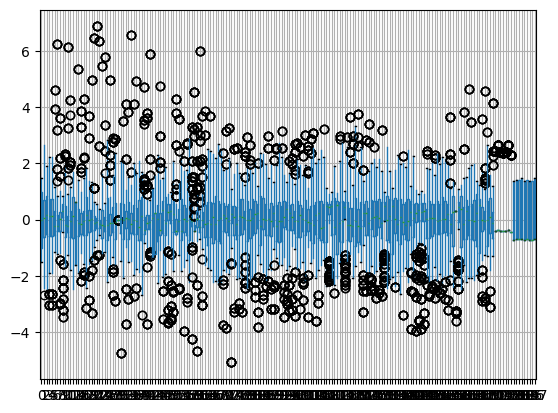

In [24]:
# _X_train.boxplot(figsize=(20,5))
pd.DataFrame(X_train).boxplot()
plt.show()

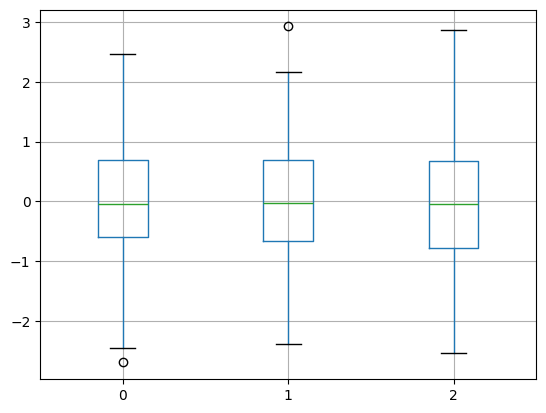

In [25]:
pd.DataFrame(Y_train).boxplot()
plt.show()

In [26]:
from sklearn.multioutput import MultiOutputRegressor
from tabpfn import TabPFNRegressor
from tabpfn.constants import ModelVersion

# Initialize the regressor
reg = MultiOutputRegressor(TabPFNRegressor(model_version=ModelVersion.V2_5))  

# Uses TabPFN-2.5 weights, trained on synthetic data only.
# To use TabPFN v2:
# regressor = TabPFNRegressor.create_default_for_version(ModelVersion.V2)

TypeError: TabPFNRegressor.__init__() got an unexpected keyword argument 'model_version'

In [ ]:
reg.fit(X_train, Y_train)

In [ ]:
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

print(Y_train_pred.shape)
print(Y_test_pred.shape)

In [ ]:
def eval_perf(y_true, y_pred):
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    return mse, mape, r2


def print_perf(data):
    for k, v in data.items():
        print(k, ":", v)


data_arr = []
for i in range(0, _Y.shape[1]):
    mse_train, mape_train, r2_train = eval_perf(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    mse_test, mape_test, r2_test = eval_perf(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )

    data = {
        "Y": f"Y-{i + 1}",
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "MAPE Train": mape_train,
        "MAPE Test": mape_test,
        "R2 Train": r2_train,
        "R2 Test": r2_test,
    }
    # print_perf(data)

    data_arr.append(data)

mse_train, mape_train, r2_train = eval_perf(y_true=Y_train, y_pred=Y_train_pred)
mse_test, mape_test, r2_test = eval_perf(y_true=Y_test, y_pred=Y_test_pred)
print_perf(data)

data = {
    "Y": "Y-All",
    "MSE Train": mse_train,
    "MSE Test": mse_test,
    "MAPE Train": mape_train,
    "MAPE Test": mape_test,
    "R2 Train": r2_train,
    "R2 Test": r2_test,
}
data_arr.append(data)
# print_perf(data)

df_eval = pd.DataFrame.from_dict(data_arr)
display(df_eval)

if SAVE_DATA:
    filename = f"eval_{dt}.xlsx"
    df_eval.to_excel(filename, index=False)

In [ ]:
for i in range(0, _Y.shape[1]):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(10, 5),
        constrained_layout=True,
        sharex=True,
        sharey=True,
    )

    display_train = PredictionErrorDisplay(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    display_train.plot(ax=axes[0])
    axes[0].set_title("Train")

    display_train = PredictionErrorDisplay(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )
    display_train.plot(ax=axes[1])
    axes[1].set_title("Test")

    if SAVE_DATA:
        filename = f"res_plot_{dt}_{i}.png"
        fig.savefig(filename, dpi=300)

    plt.show()